In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import plot_swps, get_sweeps, swp_window, get_protocol, files_from_protocol
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
%matplotlib widget

### Find you data

In [3]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Cav',
 '/home/alan/Documents/LAB/CSHL/Data/Kv',
 '/home/alan/Documents/LAB/CSHL/Data/_test.mat',
 '/home/alan/Documents/LAB/CSHL/Data/Gly',
 '/home/alan/Documents/LAB/CSHL/Data/HCN',
 '/home/alan/Documents/LAB/CSHL/Data/Nav']

In [4]:
files = glob(folders[-2]+"/*.abf")
files

[]

In [5]:
get_protocol(files)

[]

### Choose your protocol and select the files. 

In [6]:
IV_files = files_from_protocol('IV',files)
IV_files

[]

### Plot the recording

In [7]:
plt.close('all')
f = act_files[0]
plot_swps(f)

IndexError: list index out of range

### Get the sweeps and compute the IV curve

In [ ]:
swps, swp_time, sr = get_sweeps(f)
## Calculate your Voltage steps :
v_start = 0.1
v_end = 0.2
voltage = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=0)
## Calculate the baseline current:
i_start = 0
i_end = 0.09
current_baseline = np.mean(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## the pic response in your current:
i_start = 0.1
i_end = 0.2
current_window = swp_window(swps,i_start,i_end,sr,channel=0)
current_response = np.array([swp[np.argmax(np.abs(swp))] for swp in current_window])
## Correct with baseline current:
current_response -= current_baseline
## normalise
norm_currents = current_response / abs(current_response).max()

In [8]:
def IV_style(ax,
            xcoord=(0.9, 0.4),
            ycoord=(0.45, 0.9)):
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_xlabel('V (mV)')
    ax.set_ylabel('I/Cm (pA/pF)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_label_coords(xcoord[0], xcoord[1]) 
    ax.yaxis.set_label_coords(ycoord[0], ycoord[1])
    # Customize ticks to remove the 0 ticks and labels
    xticks = [tick for tick in ax.get_xticks() if tick != 0]
    yticks = [tick for tick in ax.get_yticks() if tick != 0]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

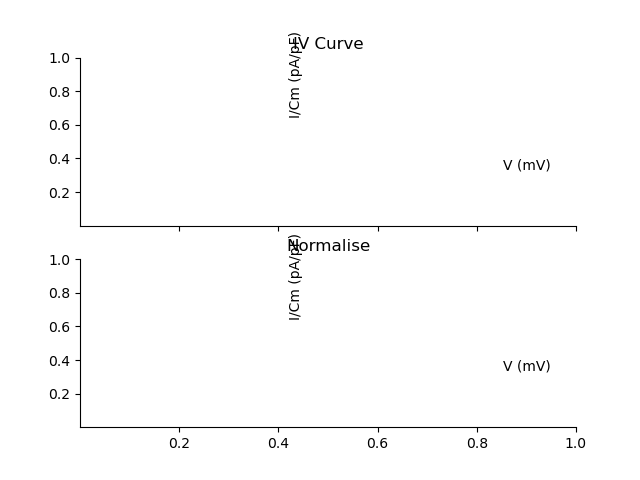

In [9]:
fig,ax = plt.subplots(2,sharex=True)
ax[0].set_title("IV Curve")
ax[1].set_title("Normalise")
ax[0].plot(voltage_step,current_response,'-o')
ax[1].plot(voltage_step,norm_g,'.')
ax[0].set_ylabel('I')
ax[1].set_xlabel('Voltage step (mV)')
ax[1].set_ylabel('I/Imax')
IV_style(ax[0], xcoord=(0.9, 0.4), ycoord=(0.45, 0.9))
IV_style(ax[1], xcoord=(0.9, 0.4), ycoord=(0.45, 0.9))
plt.show()

### Now You have the reversal potenttial you can calculate the channel conductance.

In [ ]:
## reversal potential in mV
E_rev = 0 ## from the IV curve
conductance = np.abs(current_response/(voltage_step - E_rev))
## normalise
norm_g = conductance/conductance.max()
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,conductance,'.')
ax[1].plot(voltage_step,norm_g,'.',label='Norm Conductance')
ax[1].set_ylabel('normalise activation')
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Conductance (??)')
ax[1].legend()
plt.show()

### Fit the Activation curve

In [ ]:
def fun_boltz(x, p):
    """Fit function for growth: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0 - (1.0/(1.0+np.exp((x-p[0])/p[1])))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = norm_g
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax[1].plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax[1].legend()

### Compare the activation curve from the I/Imax

In [ ]:
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,conductance,'.')
ax[1].plot(voltage_step,norm_g,'.',label='Norm Conductance')
ax[1].plot(voltage_step,norm_currents,'.',label='Norm Current')
ax[1].set_ylabel('normalise activation')
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Conductance (??)')
ax[1].legend()
plt.show()

### Now Tail currents !

In [10]:
def fit_exp(x_axis,ydata,p_guess):
    def fun_exp(t, p):
        """Fit function for decay: single exponential + offset
        p[0] : amplitude
        p[1] : tau
        """
        ## THIS IS CRUCIAL !
        ## for a good fit you need to have the 
        ## params in the range of 0-1
        amp = p[0] * 1e3 ## nA
        tau = p[1] * 1e-3 # ms
        # offset = p[2] * 1e3 ## pA
        return 1 - (amp*np.exp(-t/tau))
    
    def minimize_fun(p, x, y):
        return y-fun_exp(x, p)
    
    x = x_axis
    y = ydata
    fit_exp = leastsq(minimize_fun, p_guess, args=(x, y))
    fit_params = fit_exp[0]
    fit_trace = fun_exp(x,fit_params)
    print(f'Amplitude = {round(fit_params[0]*1e3,1)} pA // Tau = {fit_params[1]*1e-3} ms')

    return fit_params,fit_trace

In [ ]:
# Set the real time end of the step.
theorical_start = 0.71
## then the window were you want to fit
## Technically the start should be the same
## But because of Cp transients you want to cut the begining.
## Then the fit will extrapolate the first part of the trace.
i_start = 0.7103 
i_end = 0.7130
tail_current = swp_window(swps,i_start,i_end,sr,channel=0)
## normalise with baseline (end of tail =0 )
baseline = np.mean(tail_current[:,-10:],axis=1)
norm_tail_current = tail_current - baseline[:, np.newaxis]
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(tail_current.T)
ax[1].plot(norm_tail_current.T)
plt.show()

In [ ]:
Cp_delta = i_start - theorical_start
time = (np.arange(len(tail_current[0])) / sr ) + Cp_delta
p_guess = [10000,100]
p_gain = 
fig,ax = plt.subplots()
cmap = mp.colormaps['viridis']
fitted_params = []
for i,curr in enumerate(norm_tail_current[:]):
    print(f'Sweep {i}')
    p_fit,t_fit = fit_exp(time,curr,p_guess)
    fitted_params.append(p_fit)
    color = cmap(i/len(tail_current))[:-1]
    ax.plot(time,curr,color=color,alpha=0.4)
    ax.plot(time,t_fit,'--',color=color,alpha=0.8)
    ax.set_xlabel('Time (ms)')
fitted_params = np.array(fitted_params) * np.array([1e3,1e-3])
plt.show()